## 4.1 Evaluation metrics: session overview

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

## 4.2 Accuracy and dummy model

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

In [10]:
thresholds = np.linspace(0, 1, 21)
scores = []
for t in thresholds:
    churn_decision = (y_pred >= t)
    accuracy = (y_val == churn_decision).mean()
    scores.append(accuracy)
    print(f'threshold={t:.2f} accuracy={accuracy:.3f}')

threshold=0.00 accuracy=0.274
threshold=0.05 accuracy=0.509
threshold=0.10 accuracy=0.598
threshold=0.15 accuracy=0.664
threshold=0.20 accuracy=0.707
threshold=0.25 accuracy=0.737
threshold=0.30 accuracy=0.759
threshold=0.35 accuracy=0.766
threshold=0.40 accuracy=0.780
threshold=0.45 accuracy=0.793
threshold=0.50 accuracy=0.801
threshold=0.55 accuracy=0.798
threshold=0.60 accuracy=0.797
threshold=0.65 accuracy=0.784
threshold=0.70 accuracy=0.765
threshold=0.75 accuracy=0.744
threshold=0.80 accuracy=0.730
threshold=0.85 accuracy=0.726
threshold=0.90 accuracy=0.726
threshold=0.95 accuracy=0.726
threshold=1.00 accuracy=0.726


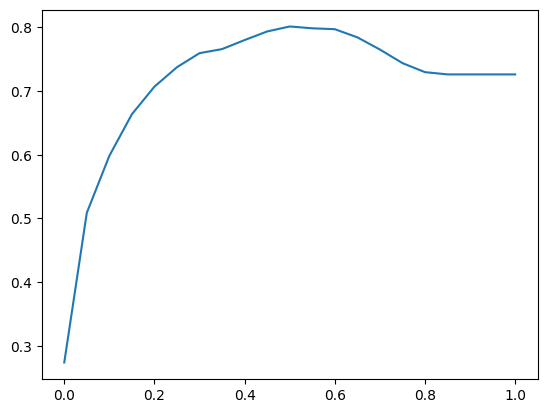

In [11]:
plt.plot(thresholds, scores)

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, (y_pred >= 0.5))

0.801277501774308

In [14]:
1 - y_val.mean()

np.float64(0.7260468417317246)

## 4.3 Confusion table

In [15]:
actual_positives = (y_val == 1)
actual_negatives = (y_val == 0)

In [16]:
t = 0.5
predicted_positives = (y_pred >= t)
predicted_negatives = (y_pred < t)

In [17]:
tp = (predicted_positives & actual_positives).sum()
tn = (predicted_negatives & actual_negatives).sum()
fp = (predicted_positives & actual_negatives).sum()
fn = (predicted_negatives & actual_positives).sum()

In [18]:
confusion_matrix = np.array([[tn, fp],
                             [fn, tp]])
confusion_matrix

array([[915, 108],
       [172, 214]])

In [19]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.08],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [20]:
(tp+tn) / confusion_matrix.sum()

np.float64(0.801277501774308)

In [21]:
precision = tp / (tp + fp) # Correct positive predictions over all positive predictions
recall = tp / (tp + fn)    # Correct positive predictions over all actual positives
precision, recall

(np.float64(0.6645962732919255), np.float64(0.5544041450777202))

## 4.5 ROC Curves
### TPR and FPR
ROC stands for Receiver Operating Characteristic

In [24]:
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
print(f"True Positive Rate: {tpr}")
print(f"False Positive Rate: {fpr}")

True Positive Rate: 0.5544041450777202
False Positive Rate: 0.10557184750733138


In [29]:
thresholds = np.linspace(0, 1, 101)
scores = []
for t in thresholds:
    predicted_positives = (y_pred >= t)
    predicted_negatives = (y_pred < t)

    tp = (predicted_positives & actual_positives).sum()
    tn = (predicted_negatives & actual_negatives).sum()
    fp = (predicted_positives & actual_negatives).sum()
    fn = (predicted_negatives & actual_positives).sum()

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    scores.append((t,tp,fp,fn,tn))

In [ ]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

Text(0.5, 1.0, 'TPR and FPR vs. Threshold')

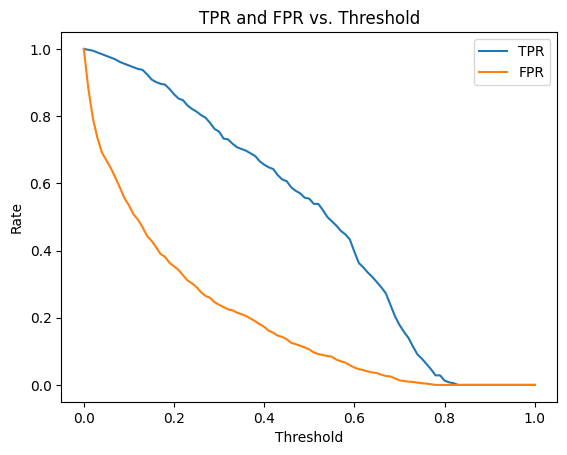

In [36]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and FPR vs. Threshold')

### Random Model

In [38]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size = len(y_val))

In [41]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [42]:
def tpr_fpr_dataframe(y_val,y_pred):
    thresholds = np.linspace(0, 1, 101)
    scores = []
    actual_positives = (y_val == 1)
    actual_negatives = (y_val == 0)
    for t in thresholds:
        predicted_positives = (y_pred >= t)
        predicted_negatives = (y_pred < t)

        tp = (predicted_positives & actual_positives).sum()
        tn = (predicted_negatives & actual_negatives).sum()
        fp = (predicted_positives & actual_negatives).sum()
        fn = (predicted_negatives & actual_positives).sum()

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)

        scores.append((t,tp,fp,fn,tn))

        df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

        df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
        df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [43]:
df_rand = tpr_fpr_dataframe(y_val,y_rand)

In [45]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


Text(0.5, 1.0, 'TPR and FPR vs. Threshold')

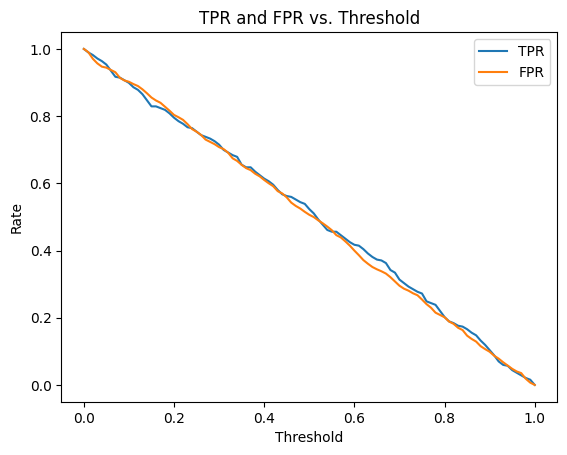

In [47]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and FPR vs. Threshold')

### Ideal Model

In [50]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [53]:
y_ideal = np.repeat([0,1],[num_neg,num_pos])

In [54]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [56]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [58]:
df_ideal = tpr_fpr_dataframe(y_ideal,y_ideal_pred)

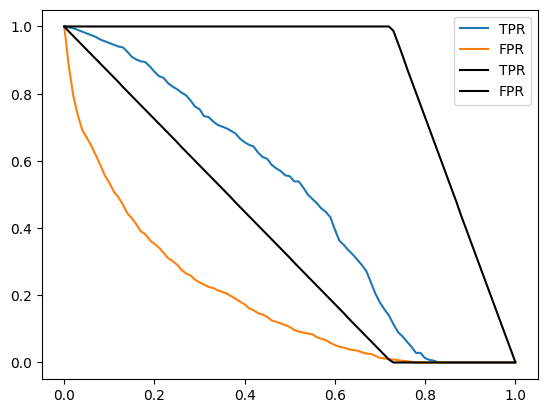

In [63]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

# plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
# plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color = 'black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color = 'black')

plt.legend()

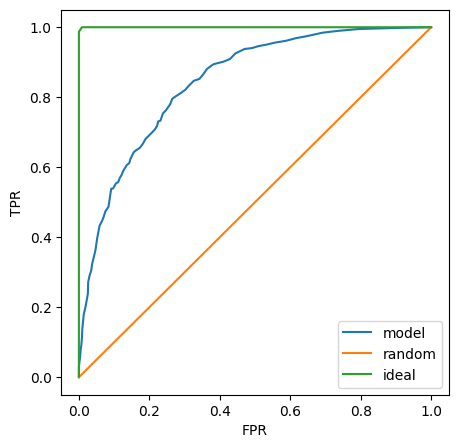

In [73]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1],[0,1],label='random')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

The IDEAL spot is on the top left, where TPR = 1 and FPR = 0 --> We want our model to be as close to that value as possible.

In [77]:
from sklearn.metrics import roc_curve

In [78]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

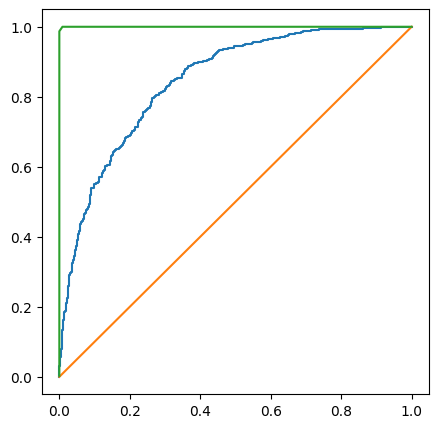

In [80]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='model')
plt.plot([0,1],[0,1],label='random')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')


## ROC AUC
### Area Under the Curve